In [1]:
from torch import nn
from torchsummary import summary
import torch 
# from U2Net_.model import U2NET
from scipy import ndimage
import PIL
import random

import os
import torch.nn.functional as F

import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL
import time

import collections
# import clip
import torch
import torch.nn as nn
from torchvision import models, transforms

p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
import CLIP_.clip as clip
from scipy import ndimage
from torchvision.utils import make_grid

device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")

In [8]:
class CLIPmaskLoss(torch.nn.Module):
    def __init__(self, clip_conv_layer_weights, mask, crop_size=224):
        super(CLIPmaskLoss, self).__init__()
        crop_size=crop_size
        # print("mask", mask.shape)
        self.clip_conv_layer_weights = clip_conv_layer_weights
        device = torch.device("cuda:0" if (
            torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
        self.clip_model_name = "ViT-B/32"
        
        self.device = device
        self.num_augs = 4
        
        self.clip_conv_loss_type = "L2"
        self.clip_fc_loss_type = "L2"  # args.clip_fc_loss_type
        
        self.mask = torch.cat([mask, mask, mask], axis=0).to(device)
        # print("self mask", self.mask.shape)
        
        self.valid_models = [
            "RN50",
            "RN101",
            "RN50x4",
            "RN50x16",
            "ViT-B/32",
            "ViT-B/16",
        ]
        assert self.clip_model_name in self.valid_models
        self.distance_metrics = \
            {
                "L2": l2_layers,
                "L1": l1_layers,
                "Cos": cos_layers
            }
        
        # background model (ViT)
        self.model, clip_preprocess = clip.load(
            self.clip_model_name, device, jit=False)
        self.model.eval()
        if self.clip_model_name.startswith("ViT"):
            self.visual_encoder = CLIPVisualEncoder(self.model)

        self.img_size = clip_preprocess.transforms[1].size
        
        self.target_transform = transforms.Compose([
            transforms.ToTensor(),
        ])  # clip normalisation
        self.normalize_transform = transforms.Compose([
            # clip_preprocess.transforms[0],  # Resize
            # clip_preprocess.transforms[1],  # CenterCrop
            clip_preprocess.transforms[-1],  # Normalize
        ])        
        
        augemntations = []
        augemntations.append(transforms.RandomPerspective(
            fill=0, p=1.0, distortion_scale=0.5))
        augemntations.append(transforms.RandomResizedCrop(
            crop_size, scale=(0.4, 0.9), ratio=(1.0, 1.0)))
        
        self.augment_trans = transforms.Compose(augemntations)
        self.clip_fc_layer_dims = None  # self.args.clip_fc_layer_dims
        self.clip_conv_layer_dims = None  # self.args.clip_conv_layer_dims
        self.clip_fc_loss_weight = 0
        self.counter = 0

    def forward(self, sketch, target, mode="train"):
        """
        Parameters
        ----------
        sketch: Torch Tensor [1, C, H, W]
        target: Torch Tensor [1, C, H, W]
        """
        conv_loss_dict = {}
        
        x = sketch.to(self.device)
        y = target.to(self.device)
        # print("x", x.shape, "y", y.shape, "mask", self.mask.shape)
        sketch_augs, img_augs, masks = [x], [y], [self.mask.unsqueeze(dim=0)]
        if mode == "train":
            for n in range(self.num_augs):
                augmented_pair = self.augment_trans(torch.cat([x, y, self.mask.unsqueeze(dim=0)]))
                sketch_augs.append(augmented_pair[0].unsqueeze(0))
                img_augs.append(augmented_pair[1].unsqueeze(0))
                masks.append(augmented_pair[2].unsqueeze(0))
        xs = torch.cat(sketch_augs, dim=0).to(self.device)
        ys = torch.cat(img_augs, dim=0).to(self.device)
        masks = torch.cat(masks, dim=0).to(self.device)
        masks[masks < 0.5] = 0
        masks[masks >= 0.5] = 1
        
        # background pass
        xs_back = self.normalize_transform(xs)
        ys_back = self.normalize_transform(ys)
        xs_fc_features, xs_conv_features = self.visual_encoder(xs_back, None)
        ys_fc_features, ys_conv_features = self.visual_encoder(ys_back, None)
        conv_loss = self.distance_metrics[self.clip_conv_loss_type](
            xs_conv_features, ys_conv_features, self.clip_model_name)
        for layer, w in enumerate(self.clip_conv_layer_weights):
            if w:
                conv_loss_dict[f"clip_conv_loss_layer{layer}"] = conv_loss[layer] * w
        if self.clip_fc_loss_weight:
            # fc distance is always cos
            fc_loss = (1 - torch.cosine_similarity(xs_fc_features,
                       ys_fc_features, dim=1)).mean()
            conv_loss_dict[f"fc"] = fc_loss * self.clip_fc_loss_weight
        self.counter += 1
        return conv_loss_dict

    def forward_inspection_clip_resnet(self, x):
        def stem(m, x):
            for conv, bn in [(m.conv1, m.bn1), (m.conv2, m.bn2), (m.conv3, m.bn3)]:
                x = m.relu(bn(conv(x)))
            x = m.avgpool(x)
            return x
        x = x.type(self.visual_model.conv1.weight.dtype)
        x = stem(self.visual_model, x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        y = self.att_pool2d(x4)
        return y, [x, x1, x2, x3, x4]


def l2_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.square(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def l1_layers(xs_conv_features, ys_conv_features, clip_model_name):
    return [torch.abs(x_conv - y_conv).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


def cos_layers(xs_conv_features, ys_conv_features, clip_model_name):
    if "RN" in clip_model_name:
        return [torch.square(x_conv, y_conv, dim=1).mean() for x_conv, y_conv in
                zip(xs_conv_features, ys_conv_features)]
    return [(1 - torch.cosine_similarity(x_conv, y_conv, dim=-1)).mean() for x_conv, y_conv in
            zip(xs_conv_features, ys_conv_features)]


class CLIPVisualEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        # print(clip_model)
        self.clip_model = clip_model
        self.featuremaps = None
        self.mask_latent = False
        self.apply_mask = False
        self.mask_only_cls = False
        self.vit_keys = None
        self.keys_loss = False
        self.hook_handlers = []
    
    def _register_hooks(self):
        for i in range(12):  # 12 resblocks in VIT visual transformer
            self.hook_handlers.append(self.clip_model.visual.transformer.resblocks[i].register_forward_hook(
                self.make_hook(i)))
    
    def _register_hooks_keys(self):
        for i in range(12):  # 12 resblocks in VIT visual transformer
            self.hook_handlers.append(self.clip_model.visual.transformer.resblocks[i].attn.attn_keys.register_forward_hook(
                self.make_hook(i)))
    
    
    def _clear_hooks(self):
        for handler in self.hook_handlers:
            handler.remove()
        self.hook_handlers = []
    
    def make_hook(self, name):
        def hook(module, input, output):
            # print("=== hook ====")
            # print(name, input[0].shape, input[0].shape, output.shape)
            if len(output.shape) == 3:
                self.featuremaps[name] = output.permute(
                    1, 0, 2)  # LND -> NLD bs, smth, 768
            else:
                self.featuremaps[name] = output
        return hook

    def forward(self, x, masks=None):
        masks_flat = torch.ones((x.shape[0], 50, 768)).to(device)
        attn_map = None
        if self.apply_mask and masks is not None:
            x_copy = x.detach().clone()
            n_channels, kernel_h, kernel_w, step = 3, 32, 32, 32
            num_patches = 49
            patches_x = x_copy.unfold(2, kernel_h, step).unfold(3, kernel_w, step).reshape(-1, n_channels, num_patches, 32, 32) 
            # shape is (batch_size, channel, num_patches, patch_size, patch_size) = (5, 3, 49, 32, 32)
            patches_mask = masks.unfold(2, kernel_h, step).unfold(3, kernel_w, step).reshape(-1, n_channels, num_patches, 32, 32) 

            masks_ = torch.ones((x.shape[0],1,7,7)).cuda()
            for i in range(masks.shape[0]):
                for j in range(num_patches):
                    zeros = (patches_mask[i, 0, j] == 0).sum() / (kernel_w * kernel_h)
                    # print(zeros)
                    if zeros > 0.2:
                        masks_[i, :, j // 7, j % 7] = 0

            mask2 = masks_[:,0].reshape(-1, 49).to(device) # shape (5, 49)
            mask2 = torch.cat([torch.ones(mask2.shape[0],1).to(device), mask2], dim=-1)
            mask2 = mask2.unsqueeze(1) # [5, 1, 50]
            attn_map = mask2.repeat(1,50,1).to(device) # 5, 50, 50
            attn_map[:,0,0] = 1
            attn_map = 1 - attn_map
            indixes = (attn_map == 0).nonzero() # shape [136, 2] [[aug_im],[index]]
            attn_map = attn_map.repeat(12,1,1).bool() # [60, 50, 50]

            if self.mask_latent:
                masks_flat = masks_[:,0].reshape(-1, 49)#.to(device) shape (5, 49)
                indixes = (masks_flat == 0).nonzero() # shape [136, 2] [[aug_im],[index]]
                for t in indixes:
                    b_num, y, x_ = t[0], t[1] // 7, t[1] % 7
                    x_copy[b_num, :, 32 * y: 32 * y + 32, 32 * x_: 32 * x_ + 32] = 0
                masks_flat = torch.cat([torch.ones(masks_flat.shape[0],1).to(device), masks_flat], dim=1)
                masks_flat = masks_flat.unsqueeze(2).repeat(1, 1, 768)
            if self.mask_only_cls:
                masks_flat = torch.ones((5, 50, 768)).to(device)
                masks_flat[:, 0, :] = 0
        
        self.featuremaps = collections.OrderedDict()
        self._register_hooks()
        fc_features = self.clip_model.encode_image(x).float() # this line fills self.featuremaps 
        # featuremaps = [self.featuremaps[k] * masks_flat for k in range(12)]
        featuremaps = [self.featuremaps[k] for k in range(12)]
        self._clear_hooks()
        return fc_features, featuremaps

In [9]:
def get_initial_points(path_svg, target_="", device=None):
    canvas_width, canvas_height, shapes, shape_groups = pydiffvg.svg_to_scene(
        path_svg)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    # plt.imshow(img.cpu().numpy())
    # plt.show()
    return points_vars

def get_path(inds_normalised, strokes_counter, device, num_segments=1, control_points_per_seg=4, canvas_width=224, canvas_height=224):
    points = []
    num_control_points = torch.zeros(num_segments, dtype = torch.int32) + (control_points_per_seg - 2)
    p0 = inds_normalised[strokes_counter]
    points.append(p0)

    for j in range(num_segments):
        radius = 0.05
        for k in range(control_points_per_seg - 1):
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            points.append(p1)
            p0 = p1
    points = torch.tensor(points).to(device)
    points[:, 0] *= canvas_width
    points[:, 1] *= canvas_height

    path = pydiffvg.Path(num_control_points = num_control_points,
                            points = points,
                            stroke_width = torch.tensor(1.5),
                            is_closed = False)
    return path


def render_points(points, canvas_size, num_strokes, num_cp, canvas_width=224, canvas_height=224):
    all_points = 0.5 * (points + 1.0) * canvas_size
    eps = 1e-4
    all_points = all_points + eps*torch.randn_like(all_points)
    all_points = all_points.reshape((-1, num_strokes, num_cp, 2))
    num_control_points = torch.zeros(1, dtype = torch.int32) + (4 - 2)

    shapes = []
    shape_groups = []
    for p in range(num_strokes):
        path = pydiffvg.Path(
            num_control_points=num_control_points, points=all_points[:,p].reshape((-1,2)),
            stroke_width=torch.tensor(1.5), is_closed=False)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(
            shape_ids=torch.tensor([len(shapes) - 1]),
            fill_color=None,
            stroke_color=torch.tensor([0,0,0,1]))
        shape_groups.append(path_group)

    # Rasterize
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])
        
    # plt.imshow(img.detach().cpu().numpy())
    # plt.show()
    return img
    

def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB")

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    # masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, torch.ones((image_scale,image_scale))#mask
    
def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0).to(device)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    # print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict



def get_initial_points_mask(mask, num_strokes, device, canvas_width=224, canvas_height=224):
    # print(mask.shape)
    mask = mask[0].cpu().numpy().astype(float)
    mask[mask > 0] = mask[mask > 0] / mask.sum()
    mask_prob = mask.astype(float) 
    # mask_prob = 
    # print(mask_prob.sum())
    k = num_strokes
    inds = np.random.choice(range(mask_prob.flatten().shape[0]), size=k, replace=False, p=mask_prob.flatten())
    inds = np.array(np.unravel_index(inds, mask_prob.shape)).T
    # print(inds)
    inds_normalised = np.zeros(inds.shape)
    inds_normalised[:, 0] =  inds[:, 1] / canvas_width
    inds_normalised[:, 1] =  inds[:, 0] / canvas_height
    inds_normalised = inds_normalised.tolist()
    # print(inds_normalised)
    shape_groups, shapes = [], []
    for i in range(num_strokes):
        # print(i)
        stroke_color = torch.tensor([0.0, 0.0, 0.0, 1.0])
        path = get_path(inds_normalised, i, device, canvas_width=canvas_width, canvas_height=canvas_height)
        shapes.append(path)
        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]),
                                            fill_color = None,
                                            stroke_color = stroke_color)
        shape_groups.append(path_group)
    render = pydiffvg.RenderFunction.apply
    scene_args = pydiffvg.RenderFunction.serialize_scene(
        canvas_width, canvas_height, shapes, shape_groups)
    img = render(canvas_width, # width
                 canvas_height, # height
                 2,   # num_samples_x
                 2,   # num_samples_y
                 0,   # seed
                 None,
                 *scene_args)

    points_vars = []
    for i, path in enumerate(shapes):
        points_vars.append(path.points)
    
    # plt.imshow(img.cpu().numpy())
    # plt.show()
    return points_vars

def sample_gumbel(shape, eps=1e-20):
    U = torch.rand(shape).to(device)
    # if is_cuda:
    #     U = U.cuda()
    return -torch.log(-torch.log(U + eps) + eps)

def gumbel_softmax_sample(logits, temperature):
    y = logits + sample_gumbel(logits.size())
    return F.softmax(y / temperature, dim=-1)

def gumbel_softmax(logits, temperature, hard=False, latent_dim=5, categorical_dim=2):
    """
    ST-gumple-softmax
    input: [*, n_class]
    return: flatten --> [*, n_class] an one-hot vector
    """
    y = gumbel_softmax_sample(logits, temperature)
    
    if not hard:
        return y.view(-1, latent_dim * categorical_dim)

    shape = y.size()
    _, ind = y.max(dim=-1)
    y_hard = torch.zeros_like(y).view(-1, shape[-1])
    y_hard.scatter_(1, ind.view(-1, 1), 1)
    y_hard = y_hard.view(*shape)
    # Set gradients w.r.t. y_hard gradients w.r.t. y
    y_hard = (y_hard - y).detach() + y
    return y_hard.view(latent_dim, categorical_dim)

def get_svg_file(path):
    files = os.listdir(path)
    files = [f for f in files if ".svg" in f]
    return files[0]  

In [10]:
class MLP(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        outdim = 1000
        # num_strokes = 32
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(num_strokes * num_cp * 2, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            # nn.ReLU(),
            # nn.Linear(1000, 1000),
            # nn.ReLU(),
            nn.Linear(outdim, num_strokes * num_cp * 2),
            # nn.Tanh()
        )
        
        # self.layers_width = nn.Sequential(
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.SELU(inplace=True),
        #     nn.Linear(num_strokes, num_strokes),
        #     nn.Sigmoid()
        # )


    def forward(self, x, widths=None):
        '''Forward pass'''
        deltas = self.layers(x)
        # print(deltas.shape)
        # print(x.flatten().shape)
        # if widths is not None:
        #     return x.flatten() + 0.1 * deltas, self.layers_width(widths)
        return x.flatten() + 0.1 * deltas

class MLPWidth(nn.Module):
    def __init__(self, num_strokes, num_cp):
        super().__init__()
        self.num_strokes = num_strokes
        outdim = 1000
        # num_strokes = 32        
        self.layers_width = nn.Sequential(
            nn.Linear(num_strokes, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, outdim),
            nn.SELU(inplace=True),
            nn.Linear(outdim, num_strokes),
            nn.Sigmoid()
        )


    def forward(self, widths=None):
        '''Forward pass'''
        res = self.layers_width(widths)#.view(self.num_strokes, 2)
        # print(res.shape)
        return res

In [11]:
def optimize_through_net(target, points_vars, mlp, mlp_opt, loss_clip, device, canvas_size=224, num_strokes=32, num_cp=4, num_iter=10, print_interval=10):    
    for t in range(num_iter):
        mlp_opt.zero_grad()
        points = mlp(points_vars)
        img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=canvas_size, canvas_height=canvas_size)
        if t % print_interval == 0:
            print('iteration:', t)
            plt.imshow(img.cpu().detach().numpy())
            plt.show()
            plt.close()
            
        img = img[:, :, :3]
        # Convert img from HWC to NCHW
        img = img.unsqueeze(0)
        img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
        
        # sketch, target
        loss_clip_ = loss_clip(img, target, mode="train")
        # print(loss_clip_)
        loss = sum(list(loss_clip_.values()))
        
        if t % print_interval == 0:
            print('render loss:', loss.item())
    
        loss.backward()
        mlp_opt.step()
    
    points = mlp(points_vars)
    img = render_points(points, canvas_size, num_strokes, num_cp, canvas_width=canvas_size, canvas_height=canvas_size)
    return img

iteration: 0


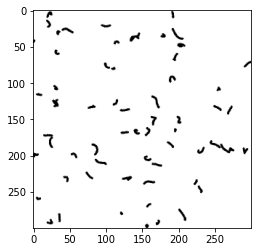

render loss: 0.0271148681640625
iteration: 20


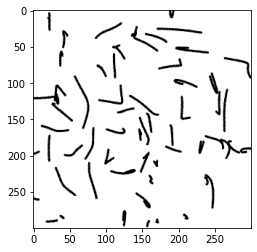

render loss: 0.0226287841796875
iteration: 40


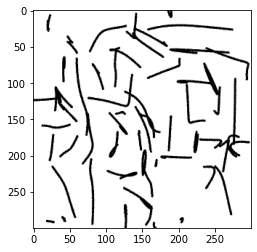

render loss: 0.02093505859375
iteration: 60


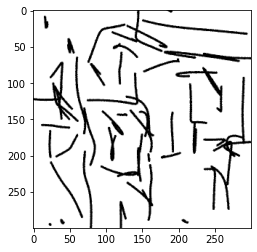

render loss: 0.0192718505859375
iteration: 80


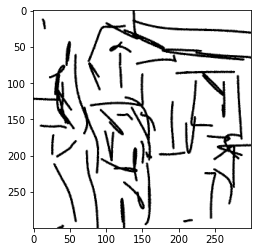

render loss: 0.0205841064453125
iteration: 100


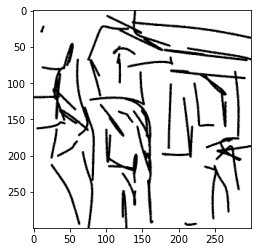

render loss: 0.0184173583984375
iteration: 120


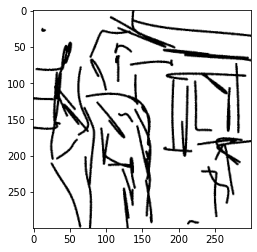

render loss: 0.018768310546875
iteration: 140


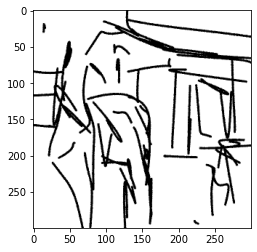

render loss: 0.0202484130859375
iteration: 160


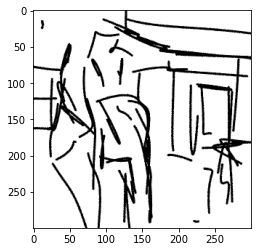

render loss: 0.0182647705078125
iteration: 180


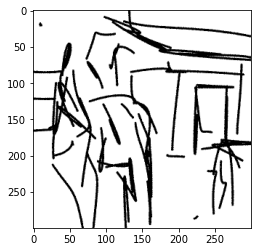

render loss: 0.0184478759765625


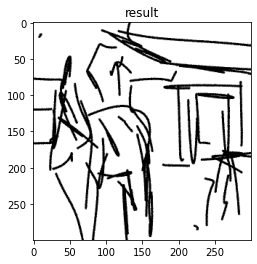

In [13]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

path_svg = "/home/vinker/dev/background_project/experiements/06_08_mask_background/mask1_semi-complex_ViT_l4_32s/mask1_semi-complex_ViT_l4_32s_seed0/svg_logs/svg_iter0.svg"
target_ = "/home/vinker/dev/background_project/notebooks/complex_level_scenes/semi-complex.jpeg"
# target_ = "/home/vinker/dev/input_images/video_sketching/swan_texture_orig_back.png"
target = Image.open(target_).resize((300, 300))

canvas_size=target.size[0]
num_strokes=64
num_cp=4

target, mask = get_target(target_, device, image_scale=canvas_size)
# print(mask.shape)
# mask = torch.ones((1,224,224))
# print(mask.shape)
points_vars = get_initial_points_mask(torch.ones((3,canvas_size,canvas_size)), num_strokes, device, canvas_width=224, canvas_height=224)
# points_vars = get_initial_points(path_svg, target_, device) # list of tensors
points_vars = torch.stack(points_vars).unsqueeze(0).to(device)
points_vars = (points_vars) / canvas_size
points_vars = 2*points_vars-1

mlp = MLP(num_strokes=num_strokes, num_cp=num_cp).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-4)

clip_conv_layer_weights=[0,0,0,0,1,0,0,0,0,0,0,0]
loss_clip = CLIPmaskLoss(clip_conv_layer_weights, mask.unsqueeze(0), crop_size=canvas_size)

im = optimize_through_net(target, points_vars, mlp, optimizer, loss_clip, device, canvas_size=canvas_size, num_strokes=num_strokes, num_cp=4,num_iter=200, print_interval=20)
plt.imshow(im.detach().cpu().numpy())
plt.title("result")
plt.show()